In [1]:
import tensorflow as tf
import numpy as np
import keras
import wget
from pathlib import Path
from typing import List, Union
import zipfile
import SimpleITK as sitk
import nibabel as nib
import pydicom
import cv2

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout 
from keras.layers import BatchNormalization

from keras.layers import Conv2DTranspose
from keras.layers import concatenate

import tensorflow_io as tfio

from keras.models import load_model
from keras.models import model_from_json

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

### Load Pretrained Model

In [2]:
def find_model_weights(file_name, model_dir):
    for root, _, files in os.walk(model_dir):
        for file in files:
            if file.startswith(file_name):
                filename = os.path.join(root, file)
    return filename

In [3]:
def download_muscle_adipose_tissue_model(model_dir):
    download_dir = Path(
        os.path.join(
            model_dir,
            ".totalsegmentator/nnunet/results/nnUNet/2d/Task927_FatMuscle/nnUNetTrainerV2__nnUNetPlansv2.1",
        )
    )
    all_path = download_dir / "all"
    if not os.path.exists(all_path):
        download_dir.mkdir(parents=True, exist_ok=True)
        wget.download(
            "https://huggingface.co/stanfordmimi/multilevel_muscle_adipose_tissue/resolve/main/all.zip",
            out=os.path.join(download_dir, "all.zip"),
        )
        with zipfile.ZipFile(os.path.join(download_dir, "all.zip"), "r") as zip_ref:
            zip_ref.extractall(download_dir)
        os.remove(os.path.join(download_dir, "all.zip"))
        wget.download(
            "https://huggingface.co/stanfordmimi/multilevel_muscle_adipose_tissue/resolve/main/plans.pkl",
            out=os.path.join(download_dir, "plans.pkl"),
        )
        print("Muscle and adipose tissue model downloaded.")
    else:
        print("Muscle and adipose tissue model already downloaded.")

In [4]:
# Import Comp2Comp model, version "stanford_v0.0.1"
model_name = "stanford_v0.0.1"
model_dir = './'
try:
    filename = find_model_weights(model_name, model_dir)
except Exception:
    print("Downloading muscle/fat model from hugging face")
    Path(model_dir).mkdir(parents=True, exist_ok=True)
    wget.download(
        f"https://huggingface.co/stanfordmimi/stanford_abct_v0.0.1/resolve/main/{model_name}.h5",
        out=os.path.join(model_dir, f"{model_name}.h5"),
    )
    filename = find_model_weights(model_name, model_dir)
    print("")

print("Loading muscle/fat model from {}".format(filename))
download_muscle_adipose_tissue_model('./')
model_c2c = load_model(filename)
c2c_weights = model_c2c.get_weights()
# model_c2c.summary()

Loading muscle/fat model from ./stanford_v0.0.1.h5
Muscle and adipose tissue model already downloaded.


2024-11-14 21:18:52.335593: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-11-14 21:18:52.335623: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-11-14 21:18:52.335626: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-11-14 21:18:52.335642: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-14 21:18:52.335652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Build New Model

In [5]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0.3, max_pooling=True): #Add trainability setting?
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, #number of filters
                  3, # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    
    conv = Conv2D(n_filters, #number of filters
                  3, # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    # Batch Normalizatiion
    conv = BatchNormalization(
        axis=-1,
        momentum=0.99,
        epsilon=0.001
    )(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    
    else:
        next_layer = conv
    
    skip_connection = conv

    return next_layer, skip_connection

In [6]:
def upsampling_block(expansive_input, contractive_input, n_filters=32, dropout_prob=0.3):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """

    up = Conv2DTranspose(n_filters,
                         3,
                         strides=(2,2),
                         padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,
                  3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)

    conv = Conv2D(n_filters,
                  3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # Batch Normalizatiion
    conv = BatchNormalization(
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
    )(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    return conv

In [7]:
# Define model architecture, same as model described in Zambrano et al
n_filters=32
n_classes = 5
inputs = Input((512,512,3))
cblock1 = conv_block(inputs, n_filters)
cblock2 = conv_block(cblock1[0], n_filters*2)
cblock3 = conv_block(cblock2[0], n_filters*4)
cblock4 = conv_block(cblock3[0], n_filters*8)
cblock5 = conv_block(cblock4[0], n_filters*16)
cblock6 = conv_block(cblock5[0], n_filters*32,max_pooling=False)

ublock7 = upsampling_block(cblock6[0], cblock5[1], n_filters*16)
ublock8 = upsampling_block(ublock7, cblock4[1], n_filters*8)
ublock9 = upsampling_block(ublock8, cblock3[1], n_filters*4)
ublock10 = upsampling_block(ublock9, cblock2[1], n_filters*2)
ublock11 = upsampling_block(ublock10, cblock1[1], n_filters)

conv12 = Conv2D(n_classes, 1, padding='same', activation='softmax')(ublock11)
model = tf.keras.Model(inputs=inputs, outputs=conv12)
# model.summary()


In [8]:
# Initialize weights from C2C
model.set_weights(c2c_weights)

# Freeze Model Weights
model.trainable = False

# Unfreeze Layers for Training
model.layers[-3].trainable = True
model.layers[-2].trainable = True

# Set output layer to 9 classes 
new_output = Conv2D(9,  1, padding='same',activation='softmax', kernel_initializer='he_normal',trainable=True)(model.layers[-2].output)
model = tf.keras.Model(inputs=model.input, outputs=new_output)


### Data Preprocessing Functions

In [9]:
## Function from Comp2Comp 
def parse_windows(windows):
    """Parse windows provided by the user.

    These windows can either be strings corresponding to popular windowing
    thresholds for CT or tuples of (upper, lower) bounds.

    Args:
        windows (list): List of strings or tuples.

    Returns:
        list: List of tuples of (upper, lower) bounds.
    """
    windowing = {
        "soft": (400, 50),
        "bone": (1800, 400),
        "liver": (150, 30),
        "spine": (250, 50),
        "custom": (500, 50),
    }
    vals = []
    for w in windows:
        if len(w) == 2:
            assert_msg = "Expected tuple of (lower, upper) bound"
            assert len(w) == 2, assert_msg
            assert isinstance(w[0], (float, int)), assert_msg
            assert isinstance(w[1], (float, int)), assert_msg
            assert w[0] < w[1], assert_msg
            vals.append(w)
            continue

        if w not in windowing:
            raise KeyError("Window {} not found".format(w))
        window_width = windowing[w][0]
        window_level = windowing[w][1]
        upper = window_level + window_width / 2
        lower = window_level - window_width / 2

        vals.append((lower, upper))

    return tuple(vals)

In [10]:
## Apply Windowing to CT Images, Stack Images

def _window(xs, bounds):
    """Apply windowing to an array of CT images.

    Args:
        xs (ndarray): NxHxW
        bounds (tuple): (lower, upper) bounds

    Returns:
        ndarray: Windowed images.
    """

    imgs = []
    for lb, ub in bounds:
        imgs.append(np.clip(xs, a_min=lb, a_max=ub))

    if len(imgs) == 1:
        return imgs[0]
    elif xs.shape[-1] == 1:
        return np.concatenate(imgs, axis=-1)
    else:
        return np.stack(imgs, axis=-1)

### Data Post-Processing Functions

In [11]:
## Function from Coursera -- Using this
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask#[0]


#### Functions from Comp2Comp, not currently used ####
def preds_to_mask(ys):
    labels = np.zeros_like(ys, dtype=np.uint8)
    l_argmax = np.argmax(ys, axis=-1)
    for c in range(labels.shape[-1]):
        labels[l_argmax == c, c] = 1
    # plt.figure()
    # plt.imshow(l_argmax[0,:,:],cmap='gray')
    # plt.colorbar()
    return labels.astype(bool)

def _fill_holes(mask,mask_id):
        int_mask = ((1 - mask) > 0.5).astype(np.int8)
        components, output, stats, _ = cv2.connectedComponentsWithStats(
            int_mask, connectivity=8
        )
        sizes = stats[1:, -1]
        components = components - 1
        # Larger threshold for SAT
        # TODO make this configurable / parameter
        if mask_id == 2:
            min_size = 50
            # min_size = 0
        else:
            min_size = 5
            # min_size = 0
        img_out = np.ones_like(mask)
        for i in range(0, components):
            if sizes[i] > min_size:
                img_out[output == i + 1] = 0
        return img_out

def fill_holes(ys):
    segs = []
    for n in range(len(ys)):
        ys_out = [
            _fill_holes(ys[n][..., i], i) for i in range(ys[n].shape[-1])
        ]
        segs.append(np.stack(ys_out, axis=2).astype(float))

    return segs

### Load Images --> Fix this

In [12]:
image_list = ['./inputs/AC42132bb-AC4213690-CT.dcm',
'./inputs/AC42132bc-AC42164ba-CT.dcm',
'./inputs/AC4213342-AC4213717-CT.dcm',
'./inputs/AC4213402-AC42137d8-CT.dcm',
'./inputs/AC4213416-AC42137ec-CT.dcm',
'./inputs/AC4213422-AC42137f9-CT.dcm',
'./inputs/AC4213461-AC4213839-CT.dcm',
'./inputs/AC42134ec-AC42138c7-CT.dcm',
'./inputs/AC4213a71-AC4213e2b-CT.dcm',
'./inputs/AC4213af5-AC4213eb5-CT.dcm',
'./inputs/AC421420b-AC4243aec-CT.dcm',
'./inputs/AC421427b-AC4214618-CT.dcm',
'./inputs/AC42142d6-AC4243063-CT.dcm',
'./inputs/AC42142f9-AC421469e-CT.dcm',
'./inputs/AC4214306-AC423f75a-CT.dcm',
'./inputs/AC421439b-AC4214750-CT.dcm',
'./inputs/AC4214412-AC42147d2-CT.dcm',
'./inputs/AC4214947-AC4214ccd-CT.dcm',
'./inputs/AC4214a78-AC4214e1f-CT.dcm',
'./inputs/AC4214bfb-AC4214fcf-CT.dcm',
'./inputs/AC4215183-AC4215506-CT.dcm',
'./inputs/AC4215221-AC42155bc-CT.dcm',
'./inputs/AC4215255-AC42155f7-CT.dcm',
'./inputs/AC4215279-AC421561e-CT.dcm',
'./inputs/AC4215897-AC4215bec-CT.dcm',
'./inputs/AC42158a1-AC4240972-CT.dcm',
'./inputs/AC4215999-AC4215d1b-CT.dcm',
'./inputs/AC42159ce-AC4215d52-CT.dcm',
'./inputs/AC4215a72-AC42439ee-CT.dcm',
'./inputs/AC4215a9a-AC4215e57-CT.dcm',
'./inputs/AC4215f4b-AC4216298-CT.dcm',
'./inputs/AC4216026-AC4216397-CT.dcm',
'./inputs/AC4216057-AC42163d0-CT.dcm',
'./inputs/AC4216186-AC4216545-CT.dcm',
'./inputs/AC42161e7-AC42165ba-CT.dcm',
'./inputs/AC4216644-AC421696b-CT.dcm',
'./inputs/AC4216651-AC421697b-CT.dcm',
'./inputs/AC4216727-AC4216a7e-CT.dcm',
'./inputs/AC4216745-AC4216a9d-CT.dcm',
'./inputs/AC421675d-AC4216ac0-CT.dcm',
'./inputs/AC42167a1-AC4216b14-CT.dcm',
'./inputs/AC421681d-AC4216bab-CT.dcm',
'./inputs/AC42168a7-AC4216c5b-CT.dcm',
'./inputs/AC421690d-AC4216cdd-CT.dcm',
'./inputs/AC4216d54-AC4216dca-CT.dcm',
'./inputs/AC4216d8b-AC4216e14-CT.dcm',
'./inputs/AC423ba9c-AC423bde2-CT.dcm',
'./inputs/AC423bada-AC423be2f-CT.dcm',
'./inputs/AC423bb02-AC423be60-CT.dcm',
'./inputs/AC423bbbe-AC423bf35-CT.dcm',
'./inputs/AC423bbe0-AC423bf5e-CT.dcm',
'./inputs/AC423bcf9-AC423c0b3-CT.dcm',
'./inputs/AC423bd5c-AC423c129-CT.dcm',
'./inputs/AC423bd83-AC42436c3-CT.dcm',
'./inputs/AC423c1ca-AC423c4df-CT.dcm',
'./inputs/AC423c225-AC423c559-CT.dcm',
'./inputs/AC423c27e-AC4243093-CT.dcm',
'./inputs/AC423c293-AC423c5e5-CT.dcm',
'./inputs/AC423c2b4-AC423c614-CT.dcm',
'./inputs/AC423c46c-AC423c847-CT.dcm',
'./inputs/AC423c8fc-AC423cc1c-CT.dcm',
'./inputs/AC423c97c-AC423ccba-CT.dcm',
'./inputs/AC423c9c1-AC423cd0e-CT.dcm',
'./inputs/AC423ca55-AC423cdc7-CT.dcm',
'./inputs/AC423ca9a-AC4240d93-CT.dcm',
'./inputs/AC423cb5d-AC423cf2c-CT.dcm',
'./inputs/AC423cb92-AC423cf72-CT.dcm',
'./inputs/AC423cfb0-AC423e01b-CT.dcm',
'./inputs/AC423cfe7-AC423d2da-CT.dcm',
'./inputs/AC423d09f-AC423d3d6-CT.dcm',
'./inputs/AC423d0b5-AC423d3f5-CT.dcm',
'./inputs/AC423d11f-AC423d47a-CT.dcm',
'./inputs/AC423d13f-AC423d4a4-CT.dcm',
'./inputs/AC423d1dd-AC423d586-CT.dcm',
'./inputs/AC423d1e6-AC423d590-CT.dcm',
'./inputs/AC423d1fb-AC4242755-CT.dcm',
'./inputs/AC423d20c-AC423d5c5-CT.dcm',
'./inputs/AC423d25f-AC423d63f-CT.dcm',
'./inputs/AC423d672-AC4242385-CT.dcm',
'./inputs/AC423d684-AC423d966-CT.dcm',
'./inputs/AC423d7be-AC423db13-CT.dcm',
'./inputs/AC423d825-AC423dbb1-CT.dcm',
'./inputs/AC423d89e-AC423dc53-CT.dcm',
'./inputs/AC423d917-AC423dcfa-CT.dcm',
'./inputs/AC423dd59-AC423e030-CT.dcm',
'./inputs/AC423dd5f-AC423e03a-CT.dcm',
'./inputs/AC423dd96-AC423e089-CT.dcm',
'./inputs/AC423dda4-AC423e097-CT.dcm',
'./inputs/AC423de2c-AC423e167-CT.dcm',
'./inputs/AC423de32-AC423e170-CT.dcm',
'./inputs/AC423de52-AC423e19f-CT.dcm',
'./inputs/AC423df13-AC423e2b9-CT.dcm',
'./inputs/AC423df5d-AC423e323-CT.dcm',
'./inputs/AC423df62-AC423e32b-CT.dcm',
'./inputs/AC423dfb2-AC423e398-CT.dcm',
'./inputs/AC423e3ea-AC423e6c1-CT.dcm',
'./inputs/AC423e4c1-AC423e7f3-CT.dcm',
'./inputs/AC423e4da-AC423e813-CT.dcm',
'./inputs/AC423e4f9-AC423e842-CT.dcm',
'./inputs/AC423e5b7-AC423e952-CT.dcm',
'./inputs/AC423e5e8-AC423e99e-CT.dcm',
'./inputs/AC423eb19-AC423ee23-CT.dcm',
'./inputs/AC423eb42-AC423ee5c-CT.dcm',
'./inputs/AC423ebd3-AC423ef2b-CT.dcm',
'./inputs/AC423ec69-AC423f006-CT.dcm',
'./inputs/AC423ec9e-AC423f058-CT.dcm',
'./inputs/AC423ecf1-AC423f0d0-CT.dcm',
'./inputs/AC423f244-AC42426f6-CT.dcm',
'./inputs/AC423f283-AC423f5e6-CT.dcm',
'./inputs/AC423f2fc-AC423f696-CT.dcm',
'./inputs/AC423f7f2-AC423fac4-CT.dcm',
'./inputs/AC423f823-AC423fb13-CT.dcm',
'./inputs/AC423f82b-AC423fb1c-CT.dcm',
'./inputs/AC423f867-AC423fb77-CT.dcm',
'./inputs/AC423f87c-AC423fb94-CT.dcm',
'./inputs/AC423f8a0-AC423fbc5-CT.dcm',
'./inputs/AC423f910-AC423fc64-CT.dcm',
'./inputs/AC423f912-AC423fc66-CT.dcm',
'./inputs/AC423f91c-AC423fc75-CT.dcm',
'./inputs/AC423f92e-AC423fc8c-CT.dcm',
'./inputs/AC423f9bf-AC423fd7c-CT.dcm',
'./inputs/AC423f9da-AC423fda3-CT.dcm',
'./inputs/AC423fe3a-AC42400ef-CT.dcm',
'./inputs/AC423ffce-AC4240331-CT.dcm',
'./inputs/AC4240050-AC4240407-CT.dcm',
'./inputs/AC42404af-AC4240752-CT.dcm',
'./inputs/AC4240502-AC42407d4-CT.dcm',
'./inputs/AC424052b-AC424080c-CT.dcm',
'./inputs/AC4240590-AC42408b6-CT.dcm',
'./inputs/AC42405b2-AC42408e8-CT.dcm',
'./inputs/AC42405bd-AC42408f5-CT.dcm',
'./inputs/AC42405d9-AC42453d8-CT.dcm',
'./inputs/AC424062b-AC424099e-CT.dcm',
'./inputs/AC4240686-AC4240a2a-CT.dcm',
'./inputs/AC4240be6-AC4240ee5-CT.dcm',
'./inputs/AC4240c99-AC424100e-CT.dcm',
'./inputs/AC4240c9a-AC4241010-CT.dcm',
'./inputs/AC4241141-AC42413cc-CT.dcm',
'./inputs/AC4241237-AC4241541-CT.dcm',
'./inputs/AC4241355-AC42416fc-CT.dcm',
'./inputs/AC4241370-AC424171f-CT.dcm',
'./inputs/AC4241380-AC424173e-CT.dcm',
'./inputs/AC4241891-AC4241b8d-CT.dcm',
'./inputs/AC4241908-AC4241c4f-CT.dcm',
'./inputs/AC424193b-AC4241ca2-CT.dcm',
'./inputs/AC424193d-AC4241ca4-CT.dcm',
'./inputs/AC424194b-AC4241cbb-CT.dcm',
'./inputs/AC42419c1-AC4241d7c-CT.dcm',
'./inputs/AC42419e6-AC4241db6-CT.dcm',
'./inputs/AC42419e9-AC4241dbb-CT.dcm',
'./inputs/AC42419f4-AC4241dc7-CT.dcm',
'./inputs/AC4241eef-AC42421f1-CT.dcm',
'./inputs/AC4241f0b-AC424546b-CT.dcm',
'./inputs/AC4241fad-AC4242327-CT.dcm',
'./inputs/AC4241fb0-AC424232f-CT.dcm',
'./inputs/AC4241fff-AC42423a6-CT.dcm',
'./inputs/AC424201d-AC42423db-CT.dcm',
'./inputs/AC424202d-AC42423f9-CT.dcm',
'./inputs/AC4242030-AC4242400-CT.dcm',
'./inputs/AC424244a-AC42426be-CT.dcm',
'./inputs/AC424248d-AC424272c-CT.dcm',
'./inputs/AC42424cd-AC4242793-CT.dcm',
'./inputs/AC424255a-AC4242886-CT.dcm',
'./inputs/AC4242575-AC42428ba-CT.dcm',
'./inputs/AC424257b-AC42428c4-CT.dcm',
'./inputs/AC42425a2-AC4242905-CT.dcm',
'./inputs/AC42425a9-AC4242914-CT.dcm',
'./inputs/AC42425ad-AC4242922-CT.dcm',
'./inputs/AC42425d3-AC424295b-CT.dcm',
'./inputs/AC42425e1-AC4242971-CT.dcm',
'./inputs/AC424265f-AC424351e-CT.dcm',
'./inputs/AC4242ad6-AC4242d5c-CT.dcm',
'./inputs/AC4242c01-AC4242f43-CT.dcm',
'./inputs/AC42430ee-AC424335e-CT.dcm',
'./inputs/AC4243244-AC42435aa-CT.dcm',
'./inputs/AC42432ab-AC424365c-CT.dcm',
'./inputs/AC42432b2-AC424366b-CT.dcm',
'./inputs/AC4243806-AC4243b1f-CT.dcm',
'./inputs/AC4243880-AC4243bff-CT.dcm',
'./inputs/AC424388d-AC4243c15-CT.dcm',
'./inputs/AC42438a5-AC4243c41-CT.dcm',
'./inputs/AC42438cf-AC4243c93-CT.dcm',
'./inputs/AC4243e01-AC4244115-CT.dcm',
'./inputs/AC4243e22-AC424415a-CT.dcm',
'./inputs/AC4243e45-AC42441a0-CT.dcm',
'./inputs/AC4243e91-AC424420d-CT.dcm',
'./inputs/AC424436b-AC42445de-CT.dcm',
'./inputs/AC4244384-AC4244608-CT.dcm',
'./inputs/AC4244430-AC4244742-CT.dcm',
'./inputs/AC424443b-AC4244757-CT.dcm',
'./inputs/AC4244451-AC4244778-CT.dcm',
'./inputs/AC42444ed-AC424488e-CT.dcm',
'./inputs/AC4244956-AC4244b95-CT.dcm',
'./inputs/AC424496f-AC4244bc7-CT.dcm',
'./inputs/AC42449e6-AC4244cad-CT.dcm',
'./inputs/AC4244a1d-AC4244d10-CT.dcm',
'./inputs/AC4244a89-AC4244dc8-CT.dcm',
'./inputs/AC4244aed-AC4244e7a-CT.dcm',
]

In [13]:
mask_list = ['./labels/AC42132bb-AC4213690.dcm',
'./labels/AC42132bc-AC42164ba.dcm',
'./labels/AC4213342-AC4213717.dcm',
'./labels/AC4213402-AC42137d8.dcm',
'./labels/AC4213416-AC42137ec.dcm',
'./labels/AC4213422-AC42137f9.dcm',
'./labels/AC4213461-AC4213839.dcm',
'./labels/AC42134ec-AC42138c7.dcm',
'./labels/AC4213a71-AC4213e2b.dcm',
'./labels/AC4213af5-AC4213eb5.dcm',
'./labels/AC421420b-AC4243aec.dcm',
'./labels/AC421427b-AC4214618.dcm',
'./labels/AC42142d6-AC4243063.dcm',
'./labels/AC42142f9-AC421469e.dcm',
'./labels/AC4214306-AC423f75a.dcm',
'./labels/AC421439b-AC4214750.dcm',
'./labels/AC4214412-AC42147d2.dcm',
'./labels/AC4214947-AC4214ccd.dcm',
'./labels/AC4214a78-AC4214e1f.dcm',
'./labels/AC4214bfb-AC4214fcf.dcm',
'./labels/AC4215183-AC4215506.dcm',
'./labels/AC4215221-AC42155bc.dcm',
'./labels/AC4215255-AC42155f7.dcm',
'./labels/AC4215279-AC421561e.dcm',
'./labels/AC4215897-AC4215bec.dcm',
'./labels/AC42158a1-AC4240972.dcm',
'./labels/AC4215999-AC4215d1b.dcm',
'./labels/AC42159ce-AC4215d52.dcm',
'./labels/AC4215a72-AC42439ee.dcm',
'./labels/AC4215a9a-AC4215e57.dcm',
'./labels/AC4215f4b-AC4216298.dcm',
'./labels/AC4216026-AC4216397.dcm',
'./labels/AC4216057-AC42163d0.dcm',
'./labels/AC4216186-AC4216545.dcm',
'./labels/AC42161e7-AC42165ba.dcm',
'./labels/AC4216644-AC421696b.dcm',
'./labels/AC4216651-AC421697b.dcm',
'./labels/AC4216727-AC4216a7e.dcm',
'./labels/AC4216745-AC4216a9d.dcm',
'./labels/AC421675d-AC4216ac0.dcm',
'./labels/AC42167a1-AC4216b14.dcm',
'./labels/AC421681d-AC4216bab.dcm',
'./labels/AC42168a7-AC4216c5b.dcm',
'./labels/AC421690d-AC4216cdd.dcm',
'./labels/AC4216d54-AC4216dca.dcm',
'./labels/AC4216d8b-AC4216e14.dcm',
'./labels/AC423ba9c-AC423bde2.dcm',
'./labels/AC423bada-AC423be2f.dcm',
'./labels/AC423bb02-AC423be60.dcm',
'./labels/AC423bbbe-AC423bf35.dcm',
'./labels/AC423bbe0-AC423bf5e.dcm',
'./labels/AC423bcf9-AC423c0b3.dcm',
'./labels/AC423bd5c-AC423c129.dcm',
'./labels/AC423bd83-AC42436c3.dcm',
'./labels/AC423c1ca-AC423c4df.dcm',
'./labels/AC423c225-AC423c559.dcm',
'./labels/AC423c27e-AC4243093.dcm',
'./labels/AC423c293-AC423c5e5.dcm',
'./labels/AC423c2b4-AC423c614.dcm',
'./labels/AC423c46c-AC423c847.dcm',
'./labels/AC423c8fc-AC423cc1c.dcm',
'./labels/AC423c97c-AC423ccba.dcm',
'./labels/AC423c9c1-AC423cd0e.dcm',
'./labels/AC423ca55-AC423cdc7.dcm',
'./labels/AC423ca9a-AC4240d93.dcm',
'./labels/AC423cb5d-AC423cf2c.dcm',
'./labels/AC423cb92-AC423cf72.dcm',
'./labels/AC423cfb0-AC423e01b.dcm',
'./labels/AC423cfe7-AC423d2da.dcm',
'./labels/AC423d09f-AC423d3d6.dcm',
'./labels/AC423d0b5-AC423d3f5.dcm',
'./labels/AC423d11f-AC423d47a.dcm',
'./labels/AC423d13f-AC423d4a4.dcm',
'./labels/AC423d1dd-AC423d586.dcm',
'./labels/AC423d1e6-AC423d590.dcm',
'./labels/AC423d1fb-AC4242755.dcm',
'./labels/AC423d20c-AC423d5c5.dcm',
'./labels/AC423d25f-AC423d63f.dcm',
'./labels/AC423d672-AC4242385.dcm',
'./labels/AC423d684-AC423d966.dcm',
'./labels/AC423d7be-AC423db13.dcm',
'./labels/AC423d825-AC423dbb1.dcm',
'./labels/AC423d89e-AC423dc53.dcm',
'./labels/AC423d917-AC423dcfa.dcm',
'./labels/AC423dd59-AC423e030.dcm',
'./labels/AC423dd5f-AC423e03a.dcm',
'./labels/AC423dd96-AC423e089.dcm',
'./labels/AC423dda4-AC423e097.dcm',
'./labels/AC423de2c-AC423e167.dcm',
'./labels/AC423de32-AC423e170.dcm',
'./labels/AC423de52-AC423e19f.dcm',
'./labels/AC423df13-AC423e2b9.dcm',
'./labels/AC423df5d-AC423e323.dcm',
'./labels/AC423df62-AC423e32b.dcm',
'./labels/AC423dfb2-AC423e398.dcm',
'./labels/AC423e3ea-AC423e6c1.dcm',
'./labels/AC423e4c1-AC423e7f3.dcm',
'./labels/AC423e4da-AC423e813.dcm',
'./labels/AC423e4f9-AC423e842.dcm',
'./labels/AC423e5b7-AC423e952.dcm',
'./labels/AC423e5e8-AC423e99e.dcm',
'./labels/AC423eb19-AC423ee23.dcm',
'./labels/AC423eb42-AC423ee5c.dcm',
'./labels/AC423ebd3-AC423ef2b.dcm',
'./labels/AC423ec69-AC423f006.dcm',
'./labels/AC423ec9e-AC423f058.dcm',
'./labels/AC423ecf1-AC423f0d0.dcm',
'./labels/AC423f244-AC42426f6.dcm',
'./labels/AC423f283-AC423f5e6.dcm',
'./labels/AC423f2fc-AC423f696.dcm',
'./labels/AC423f7f2-AC423fac4.dcm',
'./labels/AC423f823-AC423fb13.dcm',
'./labels/AC423f82b-AC423fb1c.dcm',
'./labels/AC423f867-AC423fb77.dcm',
'./labels/AC423f87c-AC423fb94.dcm',
'./labels/AC423f8a0-AC423fbc5.dcm',
'./labels/AC423f910-AC423fc64.dcm',
'./labels/AC423f912-AC423fc66.dcm',
'./labels/AC423f91c-AC423fc75.dcm',
'./labels/AC423f92e-AC423fc8c.dcm',
'./labels/AC423f9bf-AC423fd7c.dcm',
'./labels/AC423f9da-AC423fda3.dcm',
'./labels/AC423fe3a-AC42400ef.dcm',
'./labels/AC423ffce-AC4240331.dcm',
'./labels/AC4240050-AC4240407.dcm',
'./labels/AC42404af-AC4240752.dcm',
'./labels/AC4240502-AC42407d4.dcm',
'./labels/AC424052b-AC424080c.dcm',
'./labels/AC4240590-AC42408b6.dcm',
'./labels/AC42405b2-AC42408e8.dcm',
'./labels/AC42405bd-AC42408f5.dcm',
'./labels/AC42405d9-AC42453d8.dcm',
'./labels/AC424062b-AC424099e.dcm',
'./labels/AC4240686-AC4240a2a.dcm',
'./labels/AC4240be6-AC4240ee5.dcm',
'./labels/AC4240c99-AC424100e.dcm',
'./labels/AC4240c9a-AC4241010.dcm',
'./labels/AC4241141-AC42413cc.dcm',
'./labels/AC4241237-AC4241541.dcm',
'./labels/AC4241355-AC42416fc.dcm',
'./labels/AC4241370-AC424171f.dcm',
'./labels/AC4241380-AC424173e.dcm',
'./labels/AC4241891-AC4241b8d.dcm',
'./labels/AC4241908-AC4241c4f.dcm',
'./labels/AC424193b-AC4241ca2.dcm',
'./labels/AC424193d-AC4241ca4.dcm',
'./labels/AC424194b-AC4241cbb.dcm',
'./labels/AC42419c1-AC4241d7c.dcm',
'./labels/AC42419e6-AC4241db6.dcm',
'./labels/AC42419e9-AC4241dbb.dcm',
'./labels/AC42419f4-AC4241dc7.dcm',
'./labels/AC4241eef-AC42421f1.dcm',
'./labels/AC4241f0b-AC424546b.dcm',
'./labels/AC4241fad-AC4242327.dcm',
'./labels/AC4241fb0-AC424232f.dcm',
'./labels/AC4241fff-AC42423a6.dcm',
'./labels/AC424201d-AC42423db.dcm',
'./labels/AC424202d-AC42423f9.dcm',
'./labels/AC4242030-AC4242400.dcm',
'./labels/AC424244a-AC42426be.dcm',
'./labels/AC424248d-AC424272c.dcm',
'./labels/AC42424cd-AC4242793.dcm',
'./labels/AC424255a-AC4242886.dcm',
'./labels/AC4242575-AC42428ba.dcm',
'./labels/AC424257b-AC42428c4.dcm',
'./labels/AC42425a2-AC4242905.dcm',
'./labels/AC42425a9-AC4242914.dcm',
'./labels/AC42425ad-AC4242922.dcm',
'./labels/AC42425d3-AC424295b.dcm',
'./labels/AC42425e1-AC4242971.dcm',
'./labels/AC424265f-AC424351e.dcm',
'./labels/AC4242ad6-AC4242d5c.dcm',
'./labels/AC4242c01-AC4242f43.dcm',
'./labels/AC42430ee-AC424335e.dcm',
'./labels/AC4243244-AC42435aa.dcm',
'./labels/AC42432ab-AC424365c.dcm',
'./labels/AC42432b2-AC424366b.dcm',
'./labels/AC4243806-AC4243b1f.dcm',
'./labels/AC4243880-AC4243bff.dcm',
'./labels/AC424388d-AC4243c15.dcm',
'./labels/AC42438a5-AC4243c41.dcm',
'./labels/AC42438cf-AC4243c93.dcm',
'./labels/AC4243e01-AC4244115.dcm',
'./labels/AC4243e22-AC424415a.dcm',
'./labels/AC4243e45-AC42441a0.dcm',
'./labels/AC4243e91-AC424420d.dcm',
'./labels/AC424436b-AC42445de.dcm',
'./labels/AC4244384-AC4244608.dcm',
'./labels/AC4244430-AC4244742.dcm',
'./labels/AC424443b-AC4244757.dcm',
'./labels/AC4244451-AC4244778.dcm',
'./labels/AC42444ed-AC424488e.dcm',
'./labels/AC4244956-AC4244b95.dcm',
'./labels/AC424496f-AC4244bc7.dcm',
'./labels/AC42449e6-AC4244cad.dcm',
'./labels/AC4244a1d-AC4244d10.dcm',
'./labels/AC4244a89-AC4244dc8.dcm',
'./labels/AC4244aed-AC4244e7a.dcm',
]

### Train Model

In [14]:
def process_path_C2C(image_path, mask_path):
    image_path = image_path.numpy().decode("utf-8")
    mask_path = mask_path.numpy().decode("utf-8")
    img = pydicom.read_file(image_path, force=True)
    img = (img.pixel_array + int(img.RescaleIntercept)).astype("float32")
    mask = pydicom.read_file(mask_path, force=True)
    mask = (mask.pixel_array + int(mask.RescaleIntercept)).astype("float32")

    return img, mask

def tf_process_path_C2C(image_path, mask_path):
    return tf.py_function(process_path_C2C, [image_path, mask_path], [tf.float32, tf.float32])

def preprocess_C2C(image, mask, windows=['soft','bone','custom']):
    # windows = ['soft','bone','custom']
    window_imgs = _window(image, parse_windows(windows))
    return window_imgs, mask

def tf_preprocess_C2C(image, mask):
    return tf.py_function(preprocess_C2C, [image, mask], [tf.float32, tf.float32])


In [15]:
## Set Input Windows
windows = ['soft','bone','custom']

## Create Tensorflow Datasets
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

# Apply the function to the dataset
image_ds = dataset.map(tf_process_path_C2C).map(
    lambda img, mask: (tf.ensure_shape(img, (512,512)), tf.ensure_shape(mask, (512,512)))
)
processed_image_ds = image_ds.map(tf_preprocess_C2C).map(
    lambda img, mask: (tf.ensure_shape(img, (512,512,3)), tf.ensure_shape(mask, (512,512)))
)

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## Define Loss Function
    metrics=['accuracy']    # Metrics
)

EPOCHS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

# Split Datasets 80/10/10
processed_img_ds_train, processed_image_ds_valtest = keras.utils.split_dataset(processed_image_ds, left_size=0.8)
processed_image_ds_val, processed_image_ds_test = keras.utils.split_dataset(processed_image_ds_valtest, left_size=0.5)

train_dataset = processed_img_ds_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = processed_image_ds_val.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



2024-11-14 21:18:54.341716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-14 21:18:54.748047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

In [18]:
%load_ext tensorboard
%tensorboard --logdir logs # starts tensboard, will automatically update once model is training

In [19]:
logdir = os.path.join("logs")
callbacks = [
  EarlyStopping(monitor='val_loss', patience=2),
  ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
  TensorBoard(logdir, histogram_freq=1)
]

model_history = model.fit(train_dataset, epochs=EPOCHS,verbose=2,callbacks=[tensorboard_callback],validation_data=val_dataset)

Epoch 1/50


2024-11-14 21:18:59.169525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-11-14 21:18:59.170987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


5/5 - 11s - 2s/step - accuracy: 0.2208 - loss: 3.7346 - val_accuracy: 0.5280 - val_loss: 3.1769
Epoch 2/50
5/5 - 9s - 2s/step - accuracy: 0.2705 - loss: 3.5791 - val_accuracy: 0.5478 - val_loss: 3.0000
Epoch 3/50
5/5 - 9s - 2s/step - accuracy: 0.3174 - loss: 3.4146 - val_accuracy: 0.5570 - val_loss: 2.8322
Epoch 4/50
5/5 - 9s - 2s/step - accuracy: 0.3638 - loss: 3.2771 - val_accuracy: 0.5636 - val_loss: 2.6755
Epoch 5/50
5/5 - 9s - 2s/step - accuracy: 0.4045 - loss: 3.1373 - val_accuracy: 0.5682 - val_loss: 2.5288
Epoch 6/50
5/5 - 9s - 2s/step - accuracy: 0.4397 - loss: 3.0011 - val_accuracy: 0.5718 - val_loss: 2.3907
Epoch 7/50
5/5 - 9s - 2s/step - accuracy: 0.4685 - loss: 2.8714 - val_accuracy: 0.5750 - val_loss: 2.2611
Epoch 8/50
5/5 - 9s - 2s/step - accuracy: 0.4934 - loss: 2.7486 - val_accuracy: 0.5780 - val_loss: 2.1395
Epoch 9/50
5/5 - 9s - 2s/step - accuracy: 0.5147 - loss: 2.6285 - val_accuracy: 0.5814 - val_loss: 2.0252
Epoch 10/50
5/5 - 9s - 2s/step - accuracy: 0.5336 - loss

### Visualize Outputs

In [24]:
def display_outputs(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        # plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()
    
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            print(image[0].shape)
            pred_mask = model.predict(image, batch_size=1)
            print(create_mask(pred_mask).shape)
            display_outputs([image[0,:,:,0], mask[0], create_mask(pred_mask)[0]])

(512, 512, 3)
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
(32, 512, 512, 1)


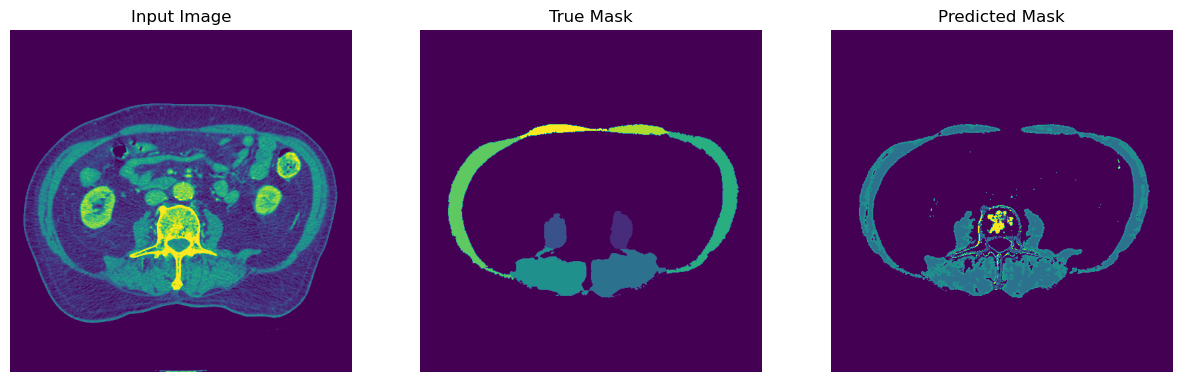

(512, 512, 3)
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
(32, 512, 512, 1)


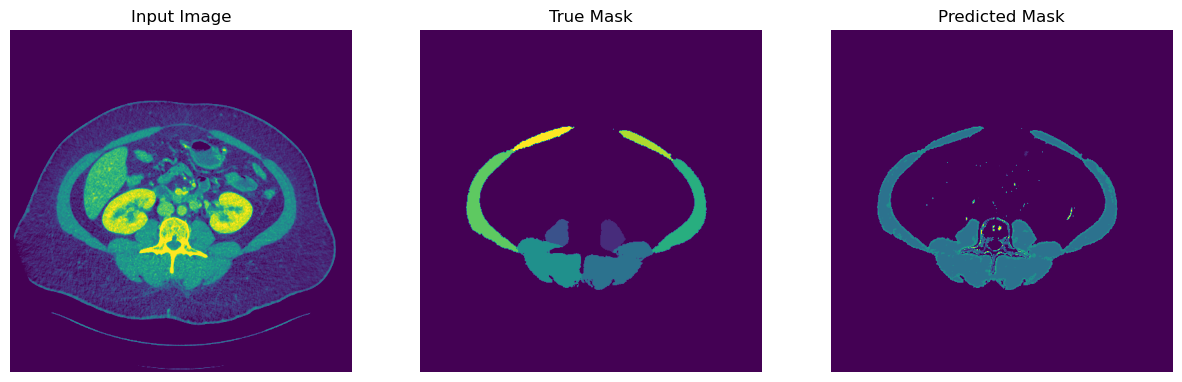

2024-11-14 21:26:57.294022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
show_predictions(train_dataset, 2)